In [1]:
#22MIY0040 | 22MIY0043

# ---------------------------------------------------------
# Road Accident Mortality Risk Prediction – Upgraded Version
# ---------------------------------------------------------

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, brier_score_loss, roc_curve, classification_report

# --- Load data ---
df = pd.read_csv("C:\\Users\\geeth\\Downloads\\accident_prediction_india (1).csv")
df["mortality"] = (df["Number of Fatalities"].fillna(0).astype(int) > 0).astype(int)

# --- Handle columns ---
cat_cols = [
    "State Name","City Name","Vehicle Type Involved","Weather Conditions","Road Type",
    "Road Condition","Lighting Conditions","Traffic Control Presence","Driver Gender",
    "Driver License Status","Alcohol Involvement","Day of Week","Time of Day"
]
num_cols = ["Number of Vehicles Involved","Number of Casualties","Speed Limit (km/h)","Driver Age"]

for c in cat_cols:
    df[c] = df[c].astype(str).fillna("Unknown").str.strip()
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(df[c].median())

# --- Encode ---
encoders = {}
for c in cat_cols:
    enc = LabelEncoder()
    df[c + "_enc"] = enc.fit_transform(df[c])
    encoders[c] = enc

# --- Split feature groups ---
spatial_cols = ["State Name_enc","City Name_enc"]
temporal_cols = ["Day of Week_enc","Time of Day_enc"]
other_cols = [
    "Vehicle Type Involved_enc","Weather Conditions_enc","Road Type_enc",
    "Road Condition_enc","Lighting Conditions_enc","Traffic Control Presence_enc",
    "Driver Gender_enc","Driver License Status_enc","Alcohol Involvement_enc"
]

X_spatial = df[spatial_cols].values
X_temporal = df[temporal_cols].values
X_other = df[other_cols].values
X_num = df[num_cols].values
y = df["mortality"].values

# --- Train/Val split ---
X_train_sp, X_val_sp, X_train_temp, X_val_temp, X_train_other, X_val_other, X_train_num, X_val_num, y_train, y_val = train_test_split(
    X_spatial, X_temporal, X_other, X_num, y, test_size=0.2, stratify=y, random_state=42
)

# --- Build CNN + LSTM hybrid ---
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

tf.random.set_seed(42)

# Spatial branch (CNN)
max_state = int(df["State Name_enc"].max()) + 1
max_city  = int(df["City Name_enc"].max()) + 1
in_state  = Input(shape=(1,), name="state_in")
in_city   = Input(shape=(1,), name="city_in")
emb_state = Embedding(max_state, 32)(in_state)
emb_city  = Embedding(max_city, 32)(in_city)
spatial_seq = Concatenate(axis=1)([emb_state, emb_city])
spatial_out = GlobalMaxPooling1D()(Conv1D(64, 2, activation="relu")(spatial_seq))

# Temporal branch (LSTM)
max_dow = int(df["Day of Week_enc"].max()) + 1
max_tod = int(df["Time of Day_enc"].max()) + 1
in_dow = Input(shape=(1,), name="dow_in")
in_tod = Input(shape=(1,), name="tod_in")
emb_dow = Embedding(max_dow, 8)(in_dow)
emb_tod = Embedding(max_tod, 8)(in_tod)
temp_seq = Concatenate(axis=1)([emb_dow, emb_tod])
temp_out = LSTM(32)(temp_seq)

# Other categorical branch
other_inputs, other_embs = [], []
for i, col in enumerate(other_cols):
    maxv = int(df[col].max()) + 1
    inp = Input(shape=(1,), name=f"other_in_{i}")
    emb = Embedding(maxv, 12)(inp)
    other_inputs.append(inp)
    other_embs.append(Flatten()(emb))
other_cat_out = Concatenate()(other_embs)

# Numeric input
num_in = Input(shape=(X_train_num.shape[1],), name="num_in")
num_dense = Dense(32, activation="relu")(num_in)

# Fusion
fusion = Concatenate()([spatial_out, temp_out, other_cat_out, num_dense])
x = Dense(128, activation="relu")(fusion)
x = Dropout(0.4)(x)
x = Dense(64, activation="relu")(x)
out = Dense(1, activation="sigmoid", name="risk_out")(x)

inputs = [in_state, in_city, in_dow, in_tod] + other_inputs + [num_in]
model = Model(inputs, out)
model.compile(optimizer=Adam(1e-3), loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC(name="auc")])
model.summary()

# --- Prepare inputs ---
def make_inputs(sp, temp, other, num):
    d = {"state_in": sp[:,0], "city_in": sp[:,1], "dow_in": temp[:,0], "tod_in": temp[:,1]}
    for i in range(other.shape[1]):
        d[f"other_in_{i}"] = other[:,i]
    d["num_in"] = num
    return d

train_in = make_inputs(X_train_sp, X_train_temp, X_train_other, X_train_num)
val_in   = make_inputs(X_val_sp, X_val_temp, X_val_other, X_val_num)

# --- Handle imbalance ---
pos = np.sum(y_train)
neg = len(y_train) - pos
class_weight = {0: (1/neg)*len(y_train)/2, 1: (1/pos)*len(y_train)/2}
print("Class weights:", class_weight)

# --- Train longer ---
history = model.fit(train_in, y_train,
                    validation_data=(val_in, y_val),
                    epochs=25, batch_size=256,
                    class_weight=class_weight,
                    verbose=2)

# --- Evaluate ---
y_pred = model.predict(val_in).ravel()
auc = roc_auc_score(y_val, y_pred)
brier = brier_score_loss(y_val, y_pred)
print(f"AUC: {auc:.4f} | Brier: {brier:.4f}")
print(classification_report(y_val, (y_pred>0.5).astype(int)))

# --- Save with risk scores ---
df["predicted_mortality_risk"] = model.predict(make_inputs(X_spatial, X_temporal, X_other, X_num)).ravel()
df.to_csv("predicted_risk_scores.csv", index=False)
print("✅ Saved 'predicted_risk_scores.csv' with predicted_mortality_risk column.")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ state_in (InputLayer)         │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ city_in (InputLayer)          │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 1, 32)             │           1,024 │ state_in[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 1, 32)             │             896 │ city_in[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dow_in (InputLayer)           │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ tod_in (InputLayer)           │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ other_in_0 (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ other_in_1 (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ other_in_2 (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ other_in_3 (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ other_in_4 (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ other_in_5 (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ other_in_6 (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ other_in_7 (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ other_in_8 (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 2, 32)             │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_2 (Embedding)       │ (None, 1, 8)              │              5

 Total params: 60,725 (237.21 KB)

 Trainable params: 60,725 (237.21 KB)

 Non-trainable params: 0 (0.00 B)

Class weights: {0: 2.830188679245283, 1: 0.6072874493927125}
Epoch 1/25
10/10 - 6s - 617ms/step - auc: 0.4751 - loss: 2.9811 - val_auc: 0.4791 - val_loss: 1.7039
Epoch 2/25
10/10 - 0s - 24ms/step - auc: 0.4918 - loss: 1.5041 - val_auc: 0.5131 - val_loss: 0.6792
Epoch 3/25
10/10 - 1s - 51ms/step - auc: 0.4949 - loss: 1.1208 - val_auc: 0.5227 - val_loss: 0.6723
Epoch 4/25
10/10 - 0s - 25ms/step - auc: 0.5052 - loss: 0.9668 - val_auc: 0.5030 - val_loss: 0.7102
Epoch 5/25
10/10 - 0s - 24ms/step - auc: 0.5009 - loss: 0.9037 - val_auc: 0.5348 - val_loss: 0.6128
Epoch 6/25
10/10 - 0s - 20ms/step - auc: 0.5086 - loss: 0.8403 - val_auc: 0.4604 - val_loss: 0.6986
Epoch 7/25
10/10 - 0s - 18ms/step - auc: 0.4812 - loss: 0.8267 - val_auc: 0.4692 - val_loss: 0.6601
Epoch 8/25
10/10 - 0s - 18ms/step - auc: 0.5033 - loss: 0.7832 - val_auc: 0.4742 - val_loss: 0.6496
Epoch 9/25
10/10 - 0s - 17ms/step - auc: 0.4810 - loss: 0.7782 - val_auc: 0.4534 - val_loss: 0.6929
Epoch 10/25
10/10 - 0s - 18ms/step - a

In [29]:
df[["State Name", "City Name", "Accident Severity", "predicted_mortality_risk"]].head(10)


,State Name,City Name,Accident Severity,predicted_mortality_risk
0,Jammu and Kashmir,Unknown,Serious,0.981789
1,Uttar Pradesh,Lucknow,Minor,0.987703
2,Chhattisgarh,Unknown,Minor,0.990039
3,Uttar Pradesh,Lucknow,Minor,0.956670
4,Sikkim,Unknown,Minor,0.992305
5,Meghalaya,Unknown,Serious,0.343501
6,Sikkim,Unknown,Fatal,0.990975
7,Himachal Pradesh,Unknown,Minor,0.972424
8,Rajasthan,Jodhpur,Fatal,0.990989
9,Rajasthan,Jodhpur,Fatal,0.971373


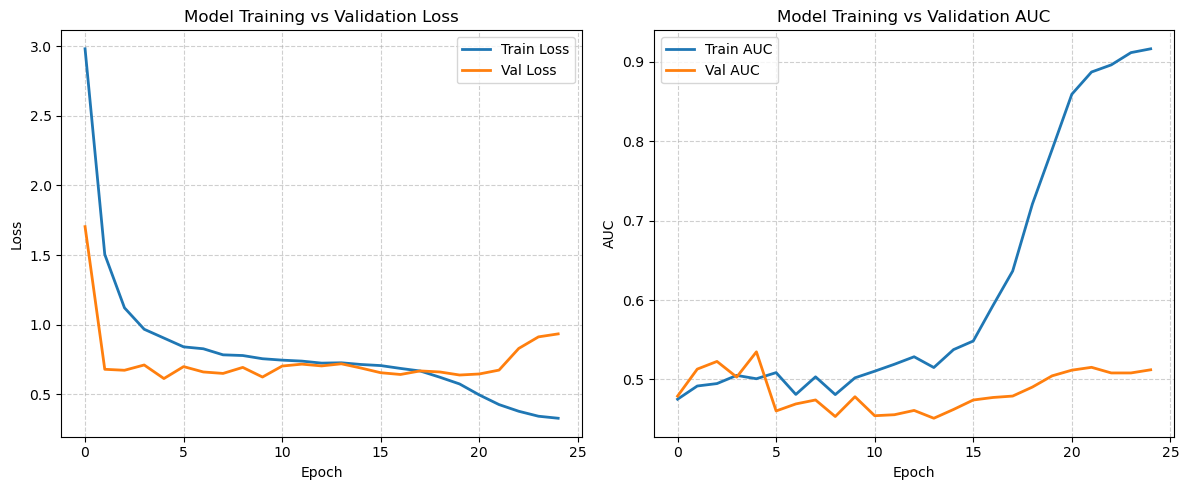

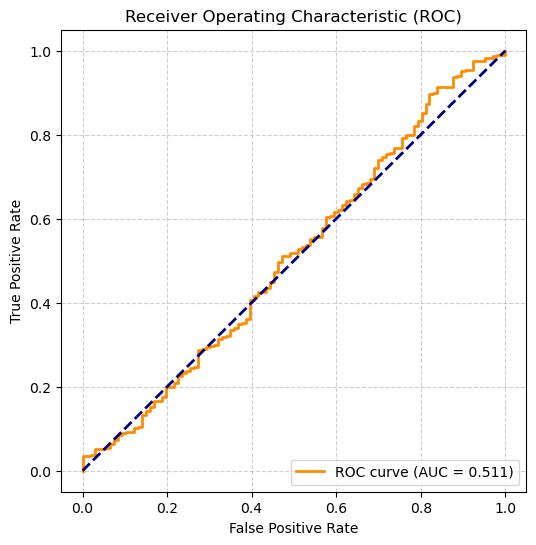

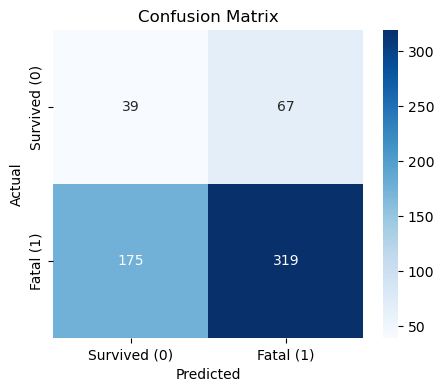


📋 Model Evaluation Summary:
     Metric                                Value
   Accuracy                             0.596667
  Precision                             0.826425
     Recall                             0.645749
   F1 Score                                0.725
        AUC <function auc at 0x0000018BD514A8E0>
Brier Score                             0.286678


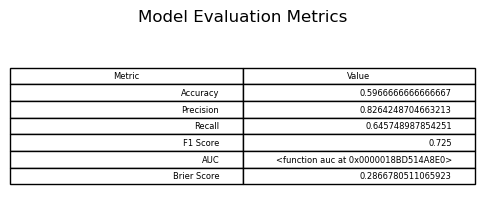

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score

# --- Plot training history ---
plt.figure(figsize=(12,5))

# Loss plot
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss", linewidth=2)
plt.plot(history.history["val_loss"], label="Val Loss", linewidth=2)
plt.title("Model Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# AUC plot
plt.subplot(1,2,2)
plt.plot(history.history["auc"], label="Train AUC", linewidth=2)
plt.plot(history.history["val_auc"], label="Val AUC", linewidth=2)
plt.title("Model Training vs Validation AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


# --- ROC Curve ---
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.title("Receiver Operating Characteristic (ROC)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


# --- Confusion Matrix ---
y_pred_class = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_val, y_pred_class)
labels = ["Survived (0)", "Fatal (1)"]

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# --- Accuracy Metrics Table ---
acc = accuracy_score(y_val, y_pred_class)
precision = classification_report(y_val, y_pred_class, output_dict=True)["1"]["precision"]
recall = classification_report(y_val, y_pred_class, output_dict=True)["1"]["recall"]
f1 = classification_report(y_val, y_pred_class, output_dict=True)["1"]["f1-score"]

metrics_table = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "AUC", "Brier Score"],
    "Value": [acc, precision, recall, f1, auc, brier]
})

print("\n📋 Model Evaluation Summary:")
print(metrics_table.to_string(index=False))

# Optional: visualize as table
plt.figure(figsize=(6,2))
plt.axis('off')
plt.table(cellText=metrics_table.values, colLabels=metrics_table.columns, loc='center')
plt.title("Model Evaluation Metrics", pad=20)
plt.show()


In [51]:
df[["State Name", "City Name", "Accident Severity", "predicted_mortality_risk"]].head(20)


,State Name,City Name,Accident Severity,predicted_mortality_risk
0,Jammu and Kashmir,Unknown,Serious,0.981789
1,Uttar Pradesh,Lucknow,Minor,0.987703
2,Chhattisgarh,Unknown,Minor,0.990039
3,Uttar Pradesh,Lucknow,Minor,0.956670
4,Sikkim,Unknown,Minor,0.992305
5,Meghalaya,Unknown,Serious,0.343501
6,Sikkim,Unknown,Fatal,0.990975
7,Himachal Pradesh,Unknown,Minor,0.972424
8,Rajasthan,Jodhpur,Fatal,0.990989
9,Rajasthan,Jodhpur,Fatal,0.971373



 Explainable AI via Permutation Importance 


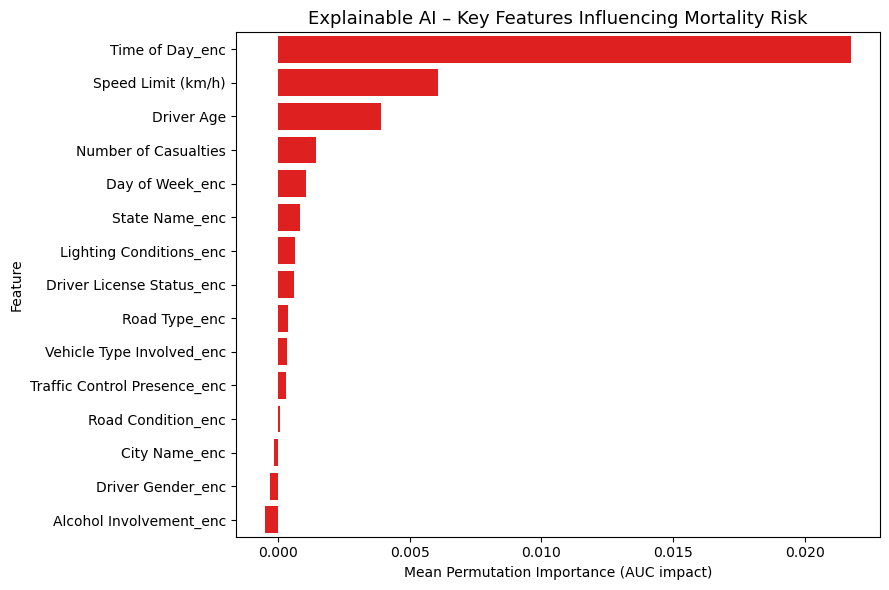


 Top 10 Influential Features:
                  Feature  Importance
          Time of Day_enc    0.021725
       Speed Limit (km/h)    0.006092
               Driver Age    0.003911
     Number of Casualties    0.001470
          Day of Week_enc    0.001085
           State Name_enc    0.000852
  Lighting Conditions_enc    0.000657
Driver License Status_enc    0.000623
            Road Type_enc    0.000393
Vehicle Type Involved_enc    0.000344


In [53]:
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("\n Explainable AI via Permutation Importance ")

# --- Wrapper so sklearn treats TensorFlow model as classifier ---
class TFModelWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model
        self.classes_ = np.array([0, 1])  # ✅ Fix: define binary class labels

    def fit(self, X, y):
        # Not used — sklearn just needs the method to exist
        return self

    def _split_inputs(self, X):
        idx = 0
        sp_cols = X_spatial.shape[1]
        temp_cols = X_temporal.shape[1]
        other_cols = X_other.shape[1]
        num_cols = X_num.shape[1]

        sp = X[:, idx:idx+sp_cols]; idx += sp_cols
        temp = X[:, idx:idx+temp_cols]; idx += temp_cols
        other = X[:, idx:idx+other_cols]; idx += other_cols
        num = X[:, idx:idx+num_cols]

        return make_inputs(sp, temp, other, num)

    def predict(self, X):
        inputs = self._split_inputs(X)
        preds = self.model.predict(inputs, verbose=0).ravel()
        return (preds > 0.5).astype(int)

    def predict_proba(self, X):
        inputs = self._split_inputs(X)
        preds = self.model.predict(inputs, verbose=0).ravel()
        return np.vstack([1 - preds, preds]).T  # shape (n_samples, 2)

# --- Combine validation inputs ---
val_combined = np.concatenate([X_val_sp, X_val_temp, X_val_other, X_val_num], axis=1)

# --- Wrap model and run permutation importance ---
wrapped_model = TFModelWrapper(model)

result = permutation_importance(
    wrapped_model,
    val_combined,
    y_val,
    n_repeats=5,
    random_state=42,
    scoring="roc_auc",
    n_jobs=-1
)

# --- Build feature importance DataFrame ---
all_features = spatial_cols + temporal_cols + other_cols + num_cols
importance_df = pd.DataFrame({
    "Feature": all_features,
    "Importance": result.importances_mean
}).sort_values("Importance", ascending=False)

# --- Visualization ---
plt.figure(figsize=(9,6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=importance_df.head(15),
    color="red"
)

plt.title("Explainable AI – Key Features Influencing Mortality Risk", fontsize=13)
plt.xlabel("Mean Permutation Importance (AUC impact)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

print("\n Top 10 Influential Features:")
print(importance_df.head(10).to_string(index=False))


C:\Users\geeth\AppData\Local\Temp\ipykernel_28012\3325907785.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


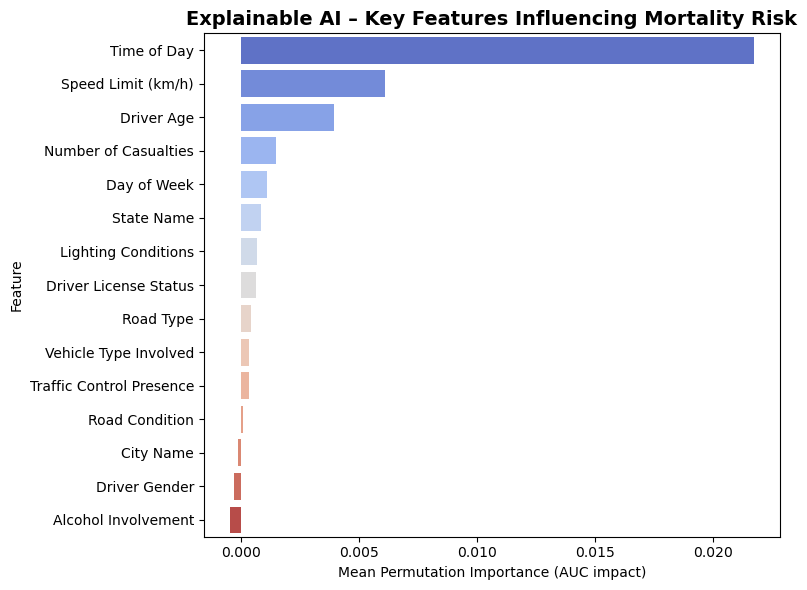

In [55]:
# Remove '_enc' suffix from feature names for cleaner visualization
importance_df["Feature"] = importance_df["Feature"].str.replace("_enc", "", regex=False)

# Sort and plot again
top_features = importance_df.sort_values(by="Importance", ascending=False).head(15)

plt.figure(figsize=(8, 6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=top_features,
    palette="coolwarm"
)
plt.title("Explainable AI – Key Features Influencing Mortality Risk", fontsize=14, weight='bold')
plt.xlabel("Mean Permutation Importance (AUC impact)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
